In [1]:
#from google.colab import drive
#drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#%cd /content/drive/MyDrive/Colab Notebooks/אלגוריתמים ויישומים בראיה ממוחשבת 046746/HW3/code

/content/drive/MyDrive/Colab Notebooks/אלגוריתמים ויישומים בראיה ממוחשבת 046746/HW3/code


In [3]:
#%pwd

'/content/drive/MyDrive/Colab Notebooks/אלגוריתמים ויישומים בראיה ממוחשבת 046746/HW3/code'

### **Part 1 - Classic Vs. Deep Learning-based Semantic Segmentation**



In [4]:
!pip install --upgrade six

ERROR: tensorflow 2.5.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0


In [4]:
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import ast
import os
import sys

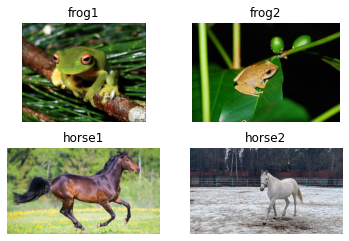

In [6]:
#section 1 - load the images
frog1 = cv2.imread('data/frogs/frog1.jpg')
frog2 = cv2.imread('data/frogs/frog2.jpg')
horse1 = cv2.imread('data/horses/horse1.png')
horse2 = cv2.imread('data/horses/horse2.jpg')

# display the images
fig = plt.figure() 
#frog1
ax = fig.add_subplot(2, 2 ,1) 
ax.imshow(cv2.cvtColor(frog1, cv2.COLOR_BGR2RGB))
ax.set_title("frog1")
_ = plt.axis('off')
# frog2
ax = fig.add_subplot(2, 2 ,2) 
ax.imshow(cv2.cvtColor(frog2, cv2.COLOR_BGR2RGB))
ax.set_title("frog2")
_ = plt.axis('off')
# horse1
ax = fig.add_subplot(2, 2 ,3) 
ax.imshow(cv2.cvtColor(horse1, cv2.COLOR_BGR2RGB))
ax.set_title("horse1")
_ = plt.axis('off')
#horse2
ax = fig.add_subplot(2, 2 ,4) 
ax.imshow(cv2.cvtColor(horse2, cv2.COLOR_BGR2RGB))
ax.set_title("horse2")
_ = plt.axis('off')

In [7]:
# section 2 - classic method for semantic segmentation - GrabCut
def GrabCut(img, rect):
  mask = np.zeros(img.shape[:2],np.uint8)
  bgdModel = np.zeros((1,65),np.float64)
  fgdModel = np.zeros((1,65),np.float64)
  cv2.grabCut(img,mask,rect,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
  mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
  img = img*mask2[:,:,np.newaxis]
  return img

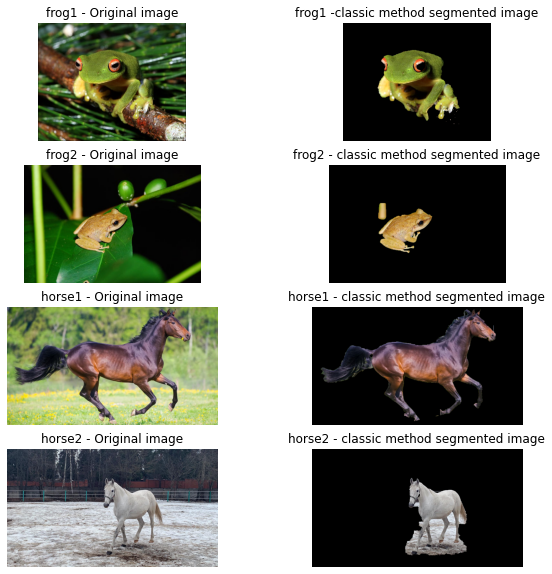

In [8]:
# section 2 - classic method for semantic segmentation - GrabCut
# apply method and display the results

###   frog1   ###
rect_frog1 = (100,50,300,300)
segmented_frog1 = GrabCut(frog1, rect_frog1)

fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(4, 2 ,1) 
ax.imshow(cv2.cvtColor(frog1, cv2.COLOR_BGR2RGB))
ax.set_title("frog1 - Original image")
_ = plt.axis('off')
ax = fig.add_subplot(4, 2 ,2) 
ax.imshow(cv2.cvtColor(segmented_frog1, cv2.COLOR_BGR2RGB))
ax.set_title("frog1 -classic method segmented image")
_ = plt.axis('off')


###   frog2   ###
rect_frog2 = (150,130,200,180)
segmented_frog2 = GrabCut(frog2, rect_frog2)
ax = fig.add_subplot(4, 2 ,3) 
ax.imshow(cv2.cvtColor(frog2, cv2.COLOR_BGR2RGB))
ax.set_title("frog2 - Original image")
_ = plt.axis('off')
ax = fig.add_subplot(4, 2 ,4) 
ax.imshow(cv2.cvtColor(segmented_frog2, cv2.COLOR_BGR2RGB))
ax.set_title("frog2 - classic method segmented image")
_ = plt.axis('off')


###   horse1   ###
rect_horse1 = (10,0,900,600)
segmented_horse1 = GrabCut(horse1, rect_horse1)
ax = fig.add_subplot(4, 2 ,5) 
ax.imshow(cv2.cvtColor(horse1, cv2.COLOR_BGR2RGB))
ax.set_title("horse1 - Original image")
_ = plt.axis('off')
ax = fig.add_subplot(4, 2 ,6) 
ax.imshow(cv2.cvtColor(segmented_horse1, cv2.COLOR_BGR2RGB))
ax.set_title("horse1 - classic method segmented image")
_ = plt.axis('off')


###   horse2   ###
rect_horse2 = (600,190,400,500)
segmented_horse2 = GrabCut(horse2, rect_horse2)
ax = fig.add_subplot(4, 2 ,7) 
ax.imshow(cv2.cvtColor(horse2, cv2.COLOR_BGR2RGB))
ax.set_title("horse2 - Original image")
_ = plt.axis('off')
ax = fig.add_subplot(4, 2 ,8) 
ax.imshow(cv2.cvtColor(segmented_horse2, cv2.COLOR_BGR2RGB))
ax.set_title("horse2 - classic method segmented image")
_ = plt.axis('off')

In [9]:
# section 2 - deep learning-based method for semantic segmentation - deeplabv3 
def DL_segmentation(filename):
  # download and load the pre-trained model
  model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
  # put in inference mode
  model.eval();
  # define device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # load an image
  input_image = Image.open(filename)

  # define the pre-processing steps
  # image->tensor, normalization
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  # perform pre-processing
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch of size 1 as expected by the model

  # send to device
  model = model.to(device)
  input_batch = input_batch.to(device)

  # forward pass
  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  return output_predictions

In [10]:
# section 2 - deep learning-based method for semantic segmentation 
labels = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']
print(["{}: {}".format(i + 1, labels[i]) for i in range(len(labels))])

['1: aeroplane', '2: bicycle', '3: bird', '4: boat', '5: bottle', '6: bus', '7: car', '8: cat', '9: chair', '10: cow', '11: diningtable', '12: dog', '13: horse', '14: motorbike', '15: person', '16: pottedplant', '17: sheep', '18: sofa', '19: train', '20: tvmonitor']


In [11]:
def det_img_from_predictions(input_image,output_predictions, lable):
  mask = torch.zeros_like(output_predictions).float()
  mask[output_predictions == lable] = 1 
  masked_img = input_image * mask.unsqueeze(2).byte().cpu().numpy()
  return masked_img

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


Text(0.5, 1.0, 'horse2 - DL segmented image')

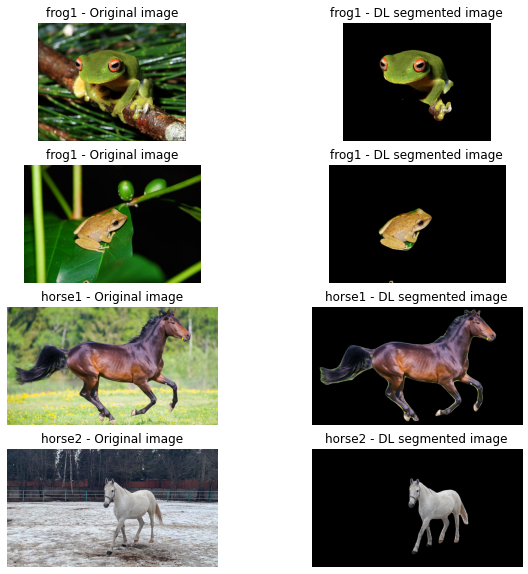

In [12]:
frog1_path = "./data/frogs/frog1.jpg"
frog2_path = "./data/frogs/frog2.jpg"
horse1_path = "./data/horses/horse1.png"
horse2_path = "./data/horses/horse2.jpg"

# apply DL sgmentation method
###   frog1   ###
OP_frog1 = DL_segmentation(frog1_path)
DL_segmented_frog1 =det_img_from_predictions(frog1,OP_frog1,3)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(4,2,1)
ax.imshow(cv2.cvtColor(frog1, cv2.COLOR_BGR2RGB))
ax.set_axis_off()
ax.set_title("frog1 - Original image")

ax = fig.add_subplot(4,2,2)
ax.imshow(cv2.cvtColor(DL_segmented_frog1, cv2.COLOR_BGR2RGB))
ax.set_axis_off()
ax.set_title("frog1 - DL segmented image")

###   frog2   ###
OP_frog2 = DL_segmentation(frog2_path)
DL_segmented_frog2 =det_img_from_predictions(frog2,OP_frog2,3)
ax = fig.add_subplot(4,2,3)
ax.imshow(cv2.cvtColor(frog2, cv2.COLOR_BGR2RGB))
ax.set_axis_off()
ax.set_title("frog1 - Original image")

ax = fig.add_subplot(4,2,4)
ax.imshow(cv2.cvtColor(DL_segmented_frog2, cv2.COLOR_BGR2RGB))
ax.set_axis_off()
ax.set_title("frog1 - DL segmented image")

###   horse1   ###
OP_horse1 = DL_segmentation(horse1_path)
DL_segmented_horse1 =det_img_from_predictions(horse1,OP_horse1,13)
ax = fig.add_subplot(4,2,5)
ax.imshow(cv2.cvtColor(horse1, cv2.COLOR_BGR2RGB))
ax.set_axis_off()
ax.set_title("horse1 - Original image")

ax = fig.add_subplot(4,2,6)
ax.imshow(cv2.cvtColor(DL_segmented_horse1, cv2.COLOR_BGR2RGB))
ax.set_axis_off()
ax.set_title("horse1 - DL segmented image")

###   horse2   ###
OP_horse2 = DL_segmentation(horse2_path)
DL_segmented_horse2 =det_img_from_predictions(horse2,OP_horse2,13)
ax = fig.add_subplot(4,2,7)
ax.imshow(cv2.cvtColor(horse2, cv2.COLOR_BGR2RGB))
ax.set_axis_off()
ax.set_title("horse2 - Original image")

ax = fig.add_subplot(4,2,8)
ax.imshow(cv2.cvtColor(DL_segmented_horse2, cv2.COLOR_BGR2RGB))
ax.set_axis_off()
ax.set_title("horse2 - DL segmented image")

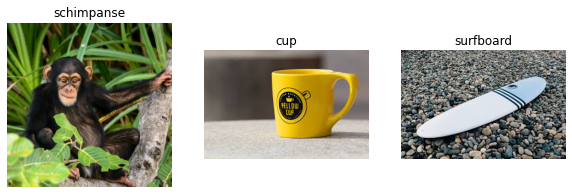

In [13]:
# step 3 - pick 3 images and display them
schimpanse = cv2.imread('my_data/schimpanse.jpg')
cup = cv2.imread('my_data/cup.jpg')
surfboard = cv2.imread('my_data/surfboard.jpg')

# display the images
fig = plt.figure(figsize=(10,10)) 
#schimpanse
ax = fig.add_subplot(1, 3 ,1) 
ax.imshow(cv2.cvtColor(schimpanse, cv2.COLOR_BGR2RGB))
ax.set_title("schimpanse")
_ = plt.axis('off')
# cup
ax = fig.add_subplot(1, 3 ,2) 
ax.imshow(cv2.cvtColor(cup, cv2.COLOR_BGR2RGB))
ax.set_title("cup")
_ = plt.axis('off')
# surfboard
ax = fig.add_subplot(1, 3 ,3) 
ax.imshow(cv2.cvtColor(surfboard, cv2.COLOR_BGR2RGB))
ax.set_title("surfboard")
_ = plt.axis('off')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


tensor([ 0,  3, 15], device='cuda:0')


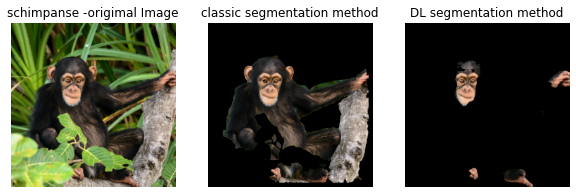

In [14]:
# step 4 - Apply each method (one classic and one deep learning-based) on the 3 images
#One image of a living being
schimpanse_path = "./my_data/schimpanse.jpg"

# apply classic method
schimpanse_rect = (50,200,1150,1000)
segmented_schimpanse = GrabCut(schimpanse, schimpanse_rect)

# apply DL method
OP_schimpanse = DL_segmentation(schimpanse_path)
print(torch.unique(OP_schimpanse))
DL_segmented_schimpanse =det_img_from_predictions(schimpanse,OP_schimpanse,15)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,3,1)
ax.imshow(cv2.cvtColor(schimpanse, cv2.COLOR_BGR2RGB))
ax.set_title("schimpanse -origimal Image")
_ = plt.axis('off')
ax = fig.add_subplot(1,3,2)
ax.imshow(cv2.cvtColor(segmented_schimpanse, cv2.COLOR_BGR2RGB))
ax.set_title("classic segmentation method")
_ = plt.axis('off')
ax = fig.add_subplot(1,3,3)
ax.imshow(cv2.cvtColor(DL_segmented_schimpanse, cv2.COLOR_BGR2RGB))
ax.set_title("DL segmentation method")
_ = plt.axis('off')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


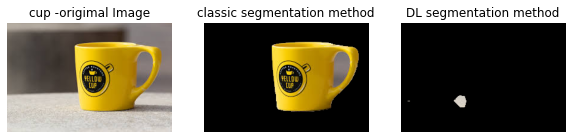

In [15]:
# step 4 - Apply each method (one classic and one deep learning-based) on the 3 images
#One image of commonly-used object
cup_path = "./my_data/cup.jpg"

# apply classic method
cup_rect = (100,25,170,125)
segmented_cup = GrabCut(cup, cup_rect)

# apply DL method
OP_cup = DL_segmentation(cup_path)
DL_segmented_cup =det_img_from_predictions(cup,OP_cup,11)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,3,1)
ax.imshow(cv2.cvtColor(cup, cv2.COLOR_BGR2RGB))
ax.set_title("cup -origimal Image")
_ = plt.axis('off')
ax = fig.add_subplot(1,3,2)
ax.imshow(cv2.cvtColor(segmented_cup, cv2.COLOR_BGR2RGB))
ax.set_title("classic segmentation method")
_ = plt.axis('off')
ax = fig.add_subplot(1,3,3)
ax.imshow(cv2.cvtColor(DL_segmented_cup, cv2.COLOR_BGR2RGB))
ax.set_title("DL segmentation method")
_ = plt.axis('off')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


tensor([0], device='cuda:0')


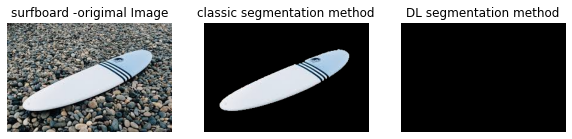

In [16]:
# step 4 - Apply each method (one classic and one deep learning-based) on the 3 images
# One image of a living being
surfboard_path = "./my_data/surfboard.jpg"

# apply classic method
surfboard_rect = (25,30,225,170)
segmented_surfboard = GrabCut(surfboard, surfboard_rect)

# apply DL method
OP_surfboard = DL_segmentation(surfboard_path)
print(torch.unique(OP_surfboard))
DL_segmented_surfboard =det_img_from_predictions(surfboard,OP_surfboard,1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,3,1)
ax.imshow(cv2.cvtColor(surfboard, cv2.COLOR_BGR2RGB))
ax.set_title("surfboard -origimal Image")
_ = plt.axis('off')
ax = fig.add_subplot(1,3,2)
ax.imshow(cv2.cvtColor(segmented_surfboard, cv2.COLOR_BGR2RGB))
ax.set_title("classic segmentation method")
_ = plt.axis('off')
ax = fig.add_subplot(1,3,3)
ax.imshow(cv2.cvtColor(DL_segmented_surfboard, cv2.COLOR_BGR2RGB))
ax.set_title("DL segmentation method")
_ = plt.axis('off')

In [17]:
# step 6 - load pre-trained classifier
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
mobilenet_v3_small.eval()
mobilenet_v3_small = mobilenet_v3_small.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


In [18]:
#step 7 - image of an animal in its natural habitat
# feed forward
dict_path = "./data/imagenet1000_clsidx_to_labels.txt"
def dictionary(path):
  file = open(path, "r")
  contents = file.read()
  dictionary = ast.literal_eval(contents)
  file.close()
  return dictionary

our_dictionary = dictionary(dict_path)

def predict(path, modle):
  image = Image.open(path)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
  ])
  # perform pre-processing
  input_tensor = preprocess(image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch of size 1 as expected by the model

  with torch.no_grad():
    lion = input_batch.to(device)
    outputs = modle(lion)
    _, predicted = torch.max(outputs.data, 1)

  print("the prediction is:{}".format(our_dictionary[predicted.cpu().numpy()[0]]))

the prediction is:lion, king of beasts, Panthera leo


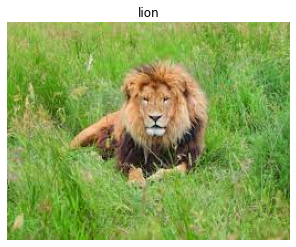

In [19]:
#step 7 - image of an animal in its natural habitat
lion = cv2.imread('my_data/lion.jpg')
#lion = cv2.resize(lion, (224,224))
# plot image
fig = plt.figure() 
ax = fig.add_subplot(1, 1 ,1) 
ax.imshow(cv2.cvtColor(lion, cv2.COLOR_BGR2RGB))
ax.set_title("lion")
_ = plt.axis('off') 

lion_path = 'my_data/lion.jpg'
predict(lion_path,mobilenet_v3_small)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


tensor([ 0, 12], device='cuda:0')


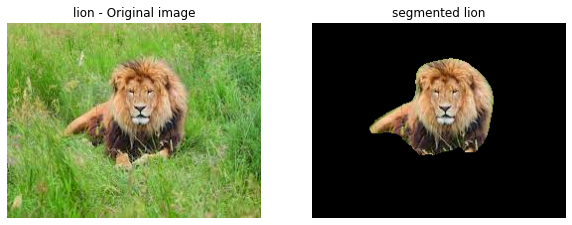

In [20]:
# step 8 - Segement the animal using classic method
#lion_rect = (40,25,120,150)
#segmented_lion = GrabCut(lion, lion_rect)

#print(lion.shape)
OP_lion = DL_segmentation(lion_path)
print(torch.unique(OP_lion))
DL_segmented_lion = det_img_from_predictions(lion,OP_lion,12)

fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(1, 2 ,1) 
ax.imshow(cv2.cvtColor(lion, cv2.COLOR_BGR2RGB))
ax.set_title("lion - Original image")
_ = plt.axis('off')
ax = fig.add_subplot(1, 2 ,2) 
ax.imshow(cv2.cvtColor(DL_segmented_lion, cv2.COLOR_BGR2RGB))
ax.set_title("segmented lion")
_ = plt.axis('off')

True

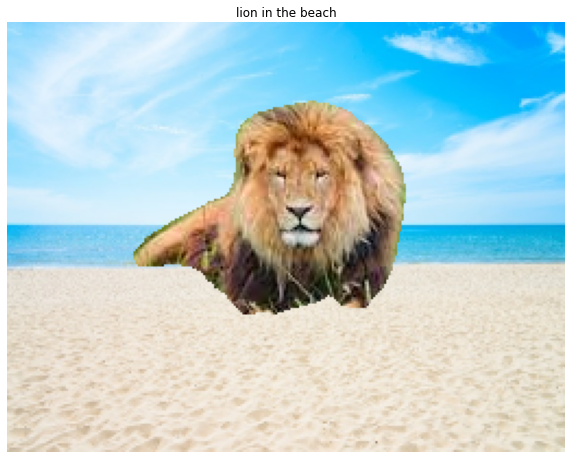

In [21]:
# step 9 - Put the the animal in a different habitat
# create a mask
lion = cv2.imread('my_data/lion.jpg')
lion_shape = lion.shape

mask = torch.zeros_like(OP_lion)
mask[OP_lion == 12] = 1 # 12 is dog
masked_img = lion * mask.unsqueeze(2).byte().cpu().numpy()

beach = cv2.imread('data/beach.jpg')
beach = cv2.resize(beach,(lion_shape[1],lion_shape[0]))
mask1 = 1 - mask
masked_beach = beach * mask1.unsqueeze(2).byte().cpu().numpy()

image = masked_img + masked_beach

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax.set_axis_off()
ax.set_title("lion in the beach")

cv2.imwrite('../output/lion_in_the_beach.jpg', image)


In [22]:
# step 10 - Feed forward the the new image
lion_in_the_beach_path = '../output/lion_in_the_beach.jpg'


predict(lion_in_the_beach_path,mobilenet_v3_small)

the prediction is:golden retriever


### **Part 2 - Jurrasic Fishbach**

In [5]:
def resize_images_in_dir(dir,size):
  for image_path in os.listdir(dir):
    img = cv2.imread(image_path)
    img_r = cv2.resize(img,size)
    #os.remove(image_path)
    cv2.imwrite(image_path,img_r)

converting video to frames...
total frames:  581


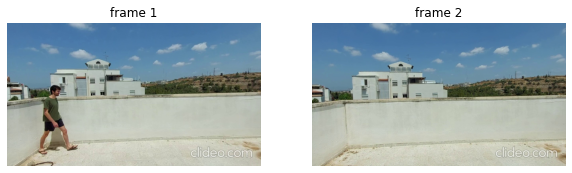

In [7]:
# section 1 - Convert the video to frames
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/אלגוריתמים ויישומים בראיה ממוחשבת 046746/HW3/code')
from frame_video_convert import video_to_image_seq
video_to_image_seq("my_data/video3.mp4","my_data/omer_frames/")

img1 = cv2.imread("my_data/omer_frames/0000.jpg")
img2 = cv2.imread("my_data/omer_frames/0200.jpg")
#print("the shape of our images:{}".format(img1.shape))


# display the images
fig = plt.figure(figsize=(10,10))
#frame1
ax = fig.add_subplot(2, 2 ,1) 
ax.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax.set_title("frame 1")
_ = plt.axis('off')
# frame2
ax = fig.add_subplot(2, 2 ,2) 
ax.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax.set_title("frame 2")
_ = plt.axis('off')

In [8]:
def DL_segmentation_without_print(filename):
  # download and load the pre-trained model
  model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
  # put in inference mode
  model.eval();
  # define device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # load an image
  input_image = Image.open(filename)

  # define the pre-processing steps
  # image->tensor, normalization
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  # perform pre-processing
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch of size 1 as expected by the model

  # send to device
  model = model.to(device)
  input_batch = input_batch.to(device)

  # forward pass
  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)
  #print("output shape: ", output.shape)
  #print("output_predictions shape: ", output_predictions.shape)

  # create a color pallette, selecting a color for each class
  palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
  colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
  colors = (colors % 255).numpy().astype("uint8")

  # plot the semantic segmentation predictions of 21 classes in each color
  r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
  r.putpalette(colors)

  return r , output_predictions, colors

In [ ]:
# section 2 - Segment ourself out of the video
frames_path = "./my_data/omer_frames/"
if not os.path.exists("my_data/omer_segmented_frames"):  
  os.mkdir("my_data/omer_segmented_frames")
for file in os.listdir(frames_path):
  file_path = os.path.join(frames_path, file)
  original_img = cv2.imread(file_path)
  file_name = os.path.join('my_data', 'omer_segmented_frames' , str(file)) 
  _ , output_predictions, _ = DL_segmentation_without_print(file_path)
  
  mask = torch.zeros_like(output_predictions.float())
  mask[output_predictions == 15] = 1 # 15 is dog
  masked_img = original_img * mask.unsqueeze(2).byte().cpu().numpy()
  cv2.imwrite(file_name,masked_img)

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cach

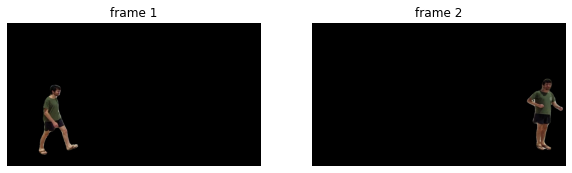

In [11]:
# plot 2 segmented images
img1 = cv2.imread("./my_data/omer_segmented_frames/0001.jpg")
img2 = cv2.imread("./my_data/omer_segmented_frames/0580.jpg")

fig = plt.figure(figsize=(10,10))
#frame1
ax = fig.add_subplot(1, 2 ,1) 
ax.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax.set_title("frame 1")
_ = plt.axis('off')
# frame2
ax = fig.add_subplot(1, 2 ,2) 
ax.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax.set_title("frame 2")
_ = plt.axis('off')


In [12]:
# section 3 - segmented dinosaur
# convert video into frames
video_to_image_seq("my_data/dinosaur_model.mp4", "./my_data/dinosaur_frames/")

converting video to frames...
total frames:  527


In [17]:
# section 3 - segmented dinosaur 
#segment all frames
frames_path = "my_data/dinosaur_frames"
if not os.path.exists("my_data/dinosaur_segmented_frames"):  
  os.mkdir("my_data/dinosaur_segmented_frames")
for file in os.listdir(frames_path):
  file_path = os.path.join(frames_path, file)
  file_name = os.path.join('my_data', 'dinosaur_segmented_frames' , str(file))
  frame = cv2.imread(file_path)

  empty_img = np.zeros_like(frame)
  RED, GREEN, BLUE = (2,1,0)
  reds = frame[:, :, RED]
  greens = frame[:, :, GREEN]
  blues = frame[:, :, BLUE]
  mask = (greens < 35) | (reds > greens) | (blues > greens)

  empty_img[:,:,0] = mask
  empty_img[:,:,1] = mask
  empty_img[:,:,2] = mask

  masked_img = empty_img * frame
  cv2.imwrite(file_name,masked_img)


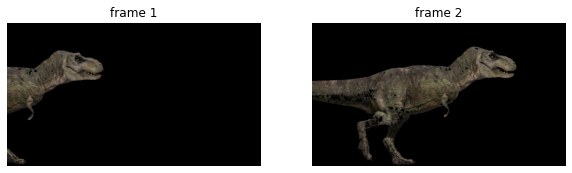

In [18]:
# section 3 - segmented dinosaur - display 2 frames
img1 = cv2.imread("my_data/dinosaur_segmented_frames/0050.jpg")
img2 = cv2.imread("my_data/dinosaur_segmented_frames/0100.jpg")

fig = plt.figure(figsize=(10,10))
#frame1
ax = fig.add_subplot(2, 2 ,1) 
ax.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax.set_title("frame 1")
_ = plt.axis('off')
# frame2
ax = fig.add_subplot(2, 2 ,2) 
ax.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax.set_title("frame 2")
_ = plt.axis('off')

In [24]:
# section 4 - Put it all together
background = cv2.imread("my_data/background.jpg")
background = cv2.resize(background,(1280,720))
dinosuar_frames_path = "my_data/dinosaur_segmented_frames"
omer_frames_path = "my_data/omer_segmented_frames"
output_path = "./my_data/merged_frames"
if not os.path.exists(output_path):  
  os.mkdir(output_path)
for file in os.listdir(dinosuar_frames_path):
  dino_file = os.path.join(dinosuar_frames_path, file)
  dino_frame = cv2.imread(dino_file)
  dino_mask = np.ones(dino_frame.shape)
  dino_mask[dino_frame > 0] = 0 
  back_masked_img =  background* dino_mask #background with o instade of dinosaur

  dino_back_frame = back_masked_img + dino_frame

  omer_file = os.path.join(omer_frames_path, file)
  omer_frame = cv2.imread(omer_file)
  omer_mask = np.ones(omer_frame.shape)
  omer_mask[omer_frame > 0] = 0 
  dino_back_masked_img =  dino_back_frame* omer_mask #background with o instade of dinosaur

  dino_omer_back = dino_back_masked_img + omer_frame
  path = os.path.join(output_path,file)
  cv2.imwrite(path,dino_omer_back)

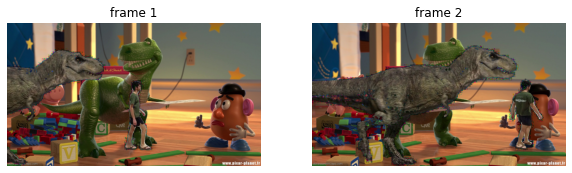

In [20]:
# section 4 - segmented dinosaur - display 2 frames
img1 = cv2.imread("./my_data/merged_frames/0050.jpg")
img2 = cv2.imread("./my_data/merged_frames/0100.jpg")

fig = plt.figure(figsize=(10,10))
#frame1
ax = fig.add_subplot(2, 2 ,1) 
ax.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax.set_title("frame 1")
_ = plt.axis('off')
# frame2
ax = fig.add_subplot(2, 2 ,2) 
ax.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax.set_title("frame 2")
_ = plt.axis('off')

In [23]:
from frame_video_convert import image_seq_to_video
output_path = "../output"
if not os.path.exists(output_path):  
  os.mkdir(output_path)
image_seq_to_video("./my_data/merged_frames",os.path.join(output_path,"video.mp4"))


(1280, 720)
writing video...
saved video @  ../output/video.mp4
